  Source     Year    Mean
0   gcag  1850-01 -0.6746
1   gcag  1850-02 -0.3334
2   gcag  1850-03 -0.5913
3   gcag  1850-04 -0.5887
4   gcag  1850-05 -0.5088
Source   datetime  GISTEMP_Mean  gcag_Mean  Difference
0      1880-01-01         -0.20    -0.3939      0.1939
1      1880-02-01         -0.25    -0.4499      0.1999
2      1880-03-01         -0.09    -0.1944      0.1044
3      1880-04-01         -0.16    -0.3380      0.1780
4      1880-05-01         -0.09    -0.3254      0.2354


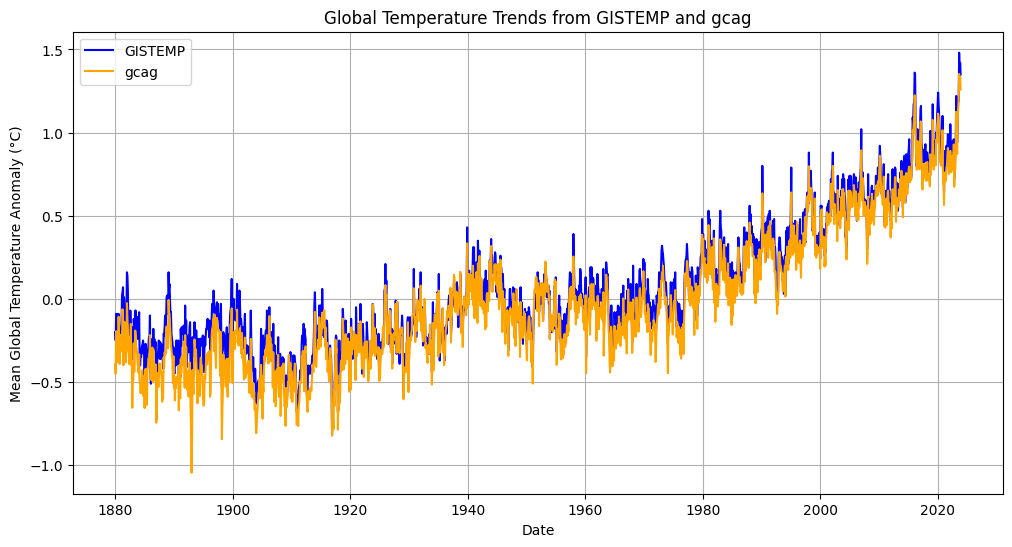

C:\Users\edanv\AppData\Local\Temp\ipykernel_7564\3557605224.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_merge['datetime'].max(), periods=120, freq='M')


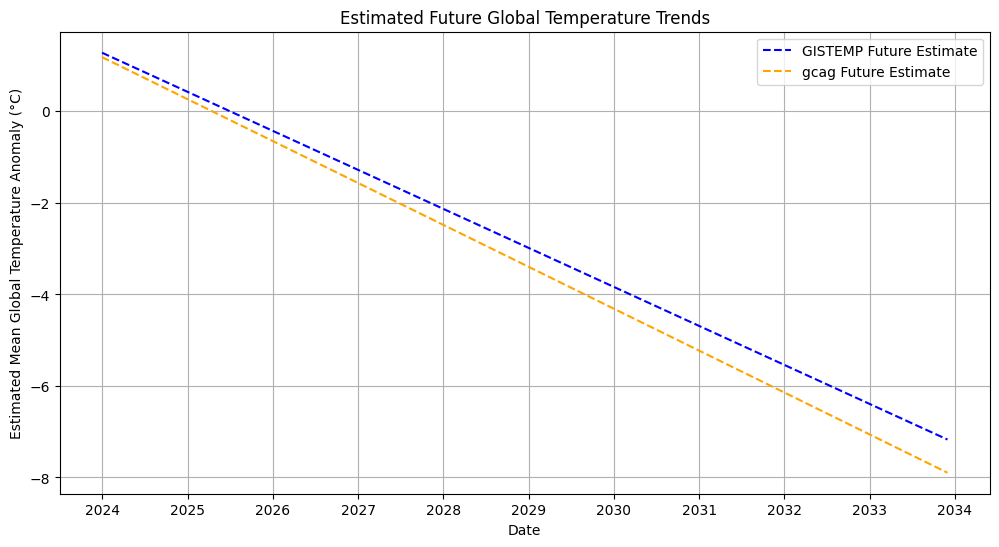

In [ ]:

#The code below where mostly copied from the teacher's example code in the lesson.
#IA was use to improve the code and make it more efficient.
#The code was analysis by me and the solutions were understood. 

#Exercises
# Exercise 1:  Read Global temperature data from Github. 

# a) Save it to both a local .csv file and a SQLite database.
# b) Convert time information to Pandas datetime format and Unix epoch.
# c) Convert data to the format, where the data source is the column header. 
# d) Compare observations from two sources (when both are available).
# e) Visualise global temperature trends (separately from two sources).
# f) Estimate future temperatures using interpolation methods.

import pandas as pd
import sqlite3
# a) Save it to both a local .csv file and a SQLite database.
url = "https://raw.githubusercontent.com/datasets/global-temp/refs/heads/main/data/monthly.csv"
data = pd.read_csv(url)
data.head
data.to_csv("./Data/global_temp.csv", index=False)

conn = sqlite3.connect('./Data/global_temp.db')
data.to_sql('global_temp', conn, if_exists='replace', index=False)
query = '''
        SELECT * FROM global_temp LIMIT 5; 
        '''
#Just limiting to 5 rows for display
result = pd.read_sql_query(query, conn)
print(result)   

# b) Convert time information to Pandas datetime format and Unix epoch.
data['datetime'] = pd.to_datetime(data['Year'], format='%Y-%m')
#unix epoch reference time is 1970-01-01 in nanoseconds, - because
data['Unix_Epoch'] = data['datetime'].astype('int64')//10**9
data.head()

# c) Convert data to the format, where the data source is the column header. 
df_merge = (
    data
    .pivot_table(index=['datetime', 'Unix_Epoch'], columns='Source', values='Mean')
    .rename(columns={'GISTEMP': 'GISTEMP_Mean', 'gcag': 'gcag_Mean'})
    .reset_index()
    .dropna(subset=['GISTEMP_Mean', 'gcag_Mean'])   # keep only rows where both sources exist
    .reset_index(drop=True)
)
df_merge.head()

#d) Compare observations from two sources (when both are available).
df_merge['Difference'] = df_merge['GISTEMP_Mean'] - df_merge['gcag_Mean']
print(df_merge[['datetime', 'GISTEMP_Mean', 'gcag_Mean', 'Difference']].head())

#e) Visualise global temperature trends (separately from two sources).
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(df_merge['datetime'], df_merge['GISTEMP_Mean'], label='GISTEMP', color='blue')
plt.plot(df_merge['datetime'], df_merge['gcag_Mean'], label='gcag', color='orange')
plt.xlabel('Date')
plt.ylabel('Mean Global Temperature Anomaly (°C)')
plt.title('Global Temperature Trends from GISTEMP and gcag')
plt.legend()
plt.grid()
plt.show()

# f) Estimate future temperatures using interpolation methods.
from scipy.interpolate import interp1d
import numpy as np          
# Prepare data for interpolation
x = df_merge['Unix_Epoch']
y_gistemp = df_merge['GISTEMP_Mean']
y_gcag = df_merge['gcag_Mean']  
# Create interpolation functions
interp_gistemp = interp1d(x, y_gistemp, kind='linear', fill_value='extrapolate')
interp_gcag = interp1d(x, y_gcag, kind='linear', fill_value='extrapolate')
# Estimate future temperatures for the next 10 years (monthly intervals)
future_dates = pd.date_range(start=df_merge['datetime'].max(), periods=120, freq='M')
future_unix_epochs = future_dates.astype('int64')//10**9
future_gistemp = interp_gistemp(future_unix_epochs)
future_gcag = interp_gcag(future_unix_epochs)
# Plot future temperature estimates
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_gistemp, label='GISTEMP Future Estimate', color='blue', linestyle='--')
plt.plot(future_dates, future_gcag, label='gcag Future Estimate', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Estimated Mean Global Temperature Anomaly (°C)')
plt.title('Estimated Future Global Temperature Trends')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Exercise 2: The zip package contains of seven .csv files. Download the package, extract the files and carry out the following:

# a) Create SQL database company_database.db where each csv file appears as a table. Use SQLite
# b) Query project id, employee id and hours worked from employee_projects and employee id's and salaries from employees_realistic. Join them on employee id.
# c) Calculate the salary costs per project, assuming that the employers salary is annual and number of working hours is 1900 per year. 
# d) Join this with the budget in projects table
# e) Calculate how large fraction of the project budget the salary costs are.

# a) Create SQL database company_database.db where each csv file appears as a table. Use SQLite
import pandas as pd
import sqlite3  
import os

# Settings
folder_path = './Data/company_data'  # Folder containing the CSV files
db_path = './Data/company_database.db'  # SQLite database file path

def create_database_from_csv(folder_path, db_path):
    # Connect to SQLite database (it will be created if it doesn't exist)
    conn = sqlite3.connect(db_path)
    
    # Loop through all CSV files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            table_name = os.path.splitext(filename)[0]  # Use the file name (without extension) as table name
            file_path = os.path.join(folder_path, filename)
            
            # Read CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Write DataFrame to SQLite table
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f'Table "{table_name}" created from "{filename}".')
    
    # Close the database connection
    conn.close()
create_database_from_csv(folder_path, db_path)
# b) Query project id, employee id and hours worked from employee_projects and employee id's and salaries from employees_realistic. Join them on employee id.
conn = sqlite3.connect(db_path)
query = '''
        SELECT ep.project_id, ep.employee_id, ep.hours_worked, er.salary
        FROM employee_projects ep
        JOIN employees_realistic er ON ep.employee_id = er.employee_id;
        '''
result = pd.read_sql_query(query, conn)
print(result.head())
# c) Calculate the salary costs per project, assuming that the employers salary is annual and number of working hours is 1900 per year.
result['hourly_rate'] = result['salary'] / 1900
result['salary_cost'] = result['hourly_rate'] * result['hours_worked']
salary_costs_per_project = result.groupby('project_id')['salary_cost'].sum().reset_index()
print(salary_costs_per_project)
# d) Join this with the budget in projects table
query_budget = '''
                SELECT project_id, budget
                FROM projects;
                '''
budget = pd.read_sql_query(query_budget, conn)
print(budget.head())
merged_data = pd.merge(salary_costs_per_project, budget, on='project_id')
print("The result of the merge is \n", merged_data)
# e) Calculate how large fraction of the project budget the salary costs are.
merged_data['salary_cost_fraction'] = merged_data['salary_cost'] / merged_data['budget']
print(merged_data[['project_id', 'salary_cost', 'budget', 'salary_cost_fraction']])


Table "customers" created from "customers.csv".
Table "departments" created from "departments.csv".
Table "employees_realistic" created from "employees_realistic.csv".
Table "employee_projects" created from "employee_projects.csv".
Table "orders" created from "orders.csv".
Table "order_items" created from "order_items.csv".
Table "projects" created from "projects.csv".
   project_id  employee_id  hours_worked     salary
0          10           25         174.7   63059.43
1           8           92          44.5   62315.72
2           9           90          59.4  139659.29
3          11           50          72.2   55178.73
4          11           64          96.4   62059.38
    project_id   salary_cost
0            1  18602.576471
1            2   3058.332900
2            3  14113.668866
3            5  27521.607915
4            6   4734.739898
5            7  14514.038858
6            8  24007.472767
7            9   6839.159714
8           10  17400.166796
9           11  10994.0691

   order_date  daily_total_sales
0  2022-01-02             789.40
1  2022-01-03             665.27
2  2022-01-15             308.90
3  2022-01-16             989.38
4  2022-01-30            1912.81


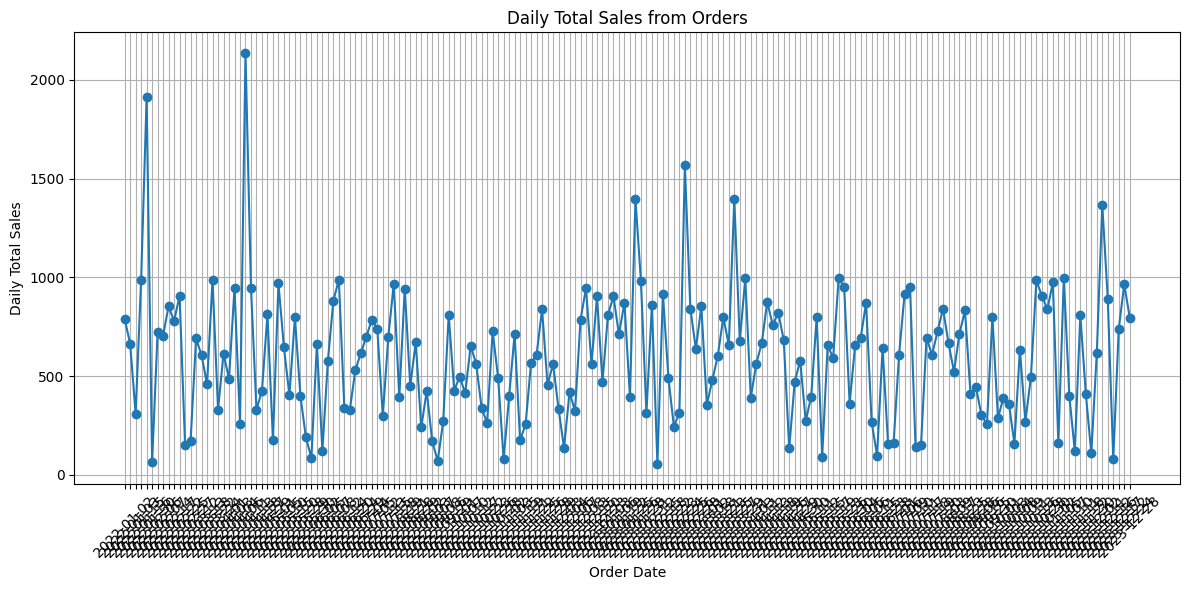

In [11]:
#Exercise 3.Use company database from Exercise 2. Use SQLite and query the daily total amount of sales from table orders. Make a line plot of daily sales using matplotlib.pyplot
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# Connect to the company database
conn = sqlite3.connect('./Data/company_database.db')
# Query daily total sales from orders table
query = '''
        SELECT order_date, SUM(amount) AS daily_total_sales
        FROM orders
        GROUP BY order_date
        ORDER BY order_date;
        '''
result = pd.read_sql_query(query, conn)
print(result.head())
# Plot daily total sales
plt.figure(figsize=(12, 6))
plt.plot(result['order_date'], result['daily_total_sales'], marker='o', linestyle='-')
plt.xlabel('Order Date')
plt.ylabel('Daily Total Sales')
plt.title('Daily Total Sales from Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 4: Use penguins data  (bigquery-public-data.ml_datasets.penguins). Write a query to calculate the average body mass, culmen length and culmen depth for females and males in different islands. Use BigQuery Console and save results first to Google Sheets and then to BigQuery table.
# Did basically the same as the teacher's example code in the lesson.
# ''''''
# SELECT
# island,
# sex,
# AVG(body_mass_g) as avg_body_mass,
# AVG(culmen_length_mm) as avg_culmen_lenght,
# AVG(culmen_depth_mm) as avg_culmen_depth
# FROM 'bigquery-public-data.ml_datasets.penguins'
# GROUP BY island, sex '''

Total cost over 5 years: $5,472


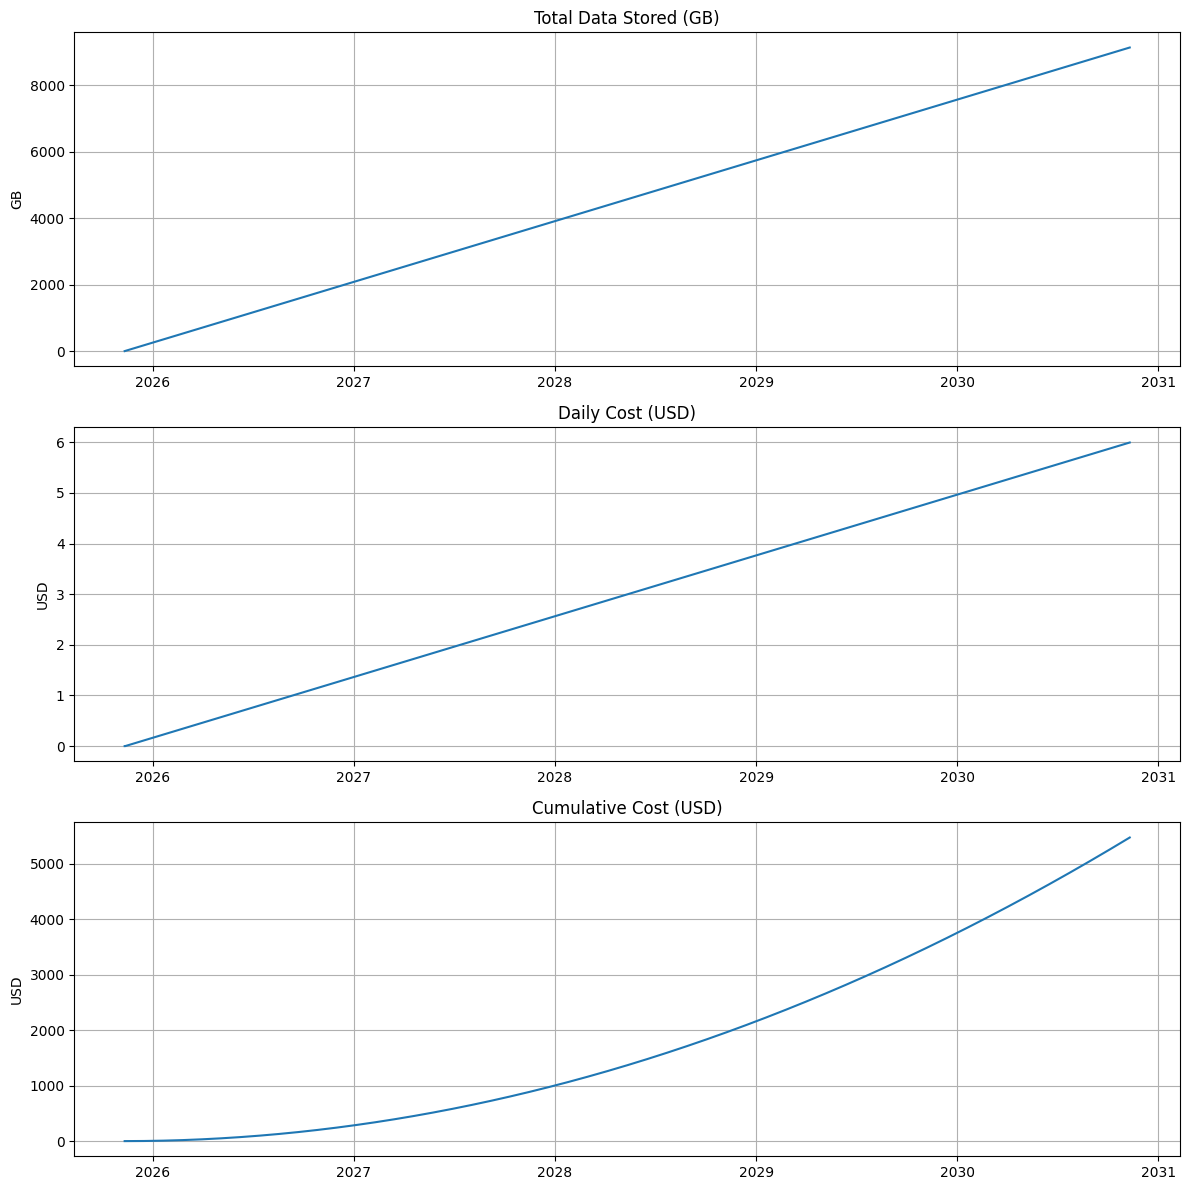

In [1]:
# 5: Estimate data storage costs over five years in BigQuery for a company that collects 5 Gb of data every day and keeps all the old data. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
hourly_price = 0.00002739726          # USD per GB per hour (active logical storage)
daily_price = hourly_price * 24       # USD per GB per day
daily_ingest_gb = 5                   # New data per day
free_tier_gb = 10                     # First 10 GB free each month (approx)
start_date = "2025-11-11"
days = 5 * 365 + 1                    # 5 years (including one leap year)

# --- Dataframe generation ---
df = pd.DataFrame({
    "time": pd.date_range(start_date, periods=days),
    "new_data": daily_ingest_gb
})

df["total_data"] = df["new_data"].cumsum()
df["daily_bill"] = np.maximum((df["total_data"] - free_tier_gb) * daily_price, 0)
df["cumulative_bill"] = df["daily_bill"].cumsum()

# --- Output ---
total_cost = round(df["cumulative_bill"].iloc[-1])
print(f"Total cost over 5 years: ${total_cost:,}")

# --- Plots ---
plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.plot(df["time"], df["total_data"])
plt.title("Total Data Stored (GB)")
plt.ylabel("GB")
plt.grid()

plt.subplot(3,1,2)
plt.plot(df["time"], df["daily_bill"])
plt.title("Daily Cost (USD)")
plt.ylabel("USD")
plt.grid()

plt.subplot(3,1,3)
plt.plot(df["time"], df["cumulative_bill"])
plt.title("Cumulative Cost (USD)")
plt.ylabel("USD")
plt.grid()

plt.tight_layout()
plt.show()



In [3]:
# 6: Use World Bank population data (bigquery-public-data.world_bank_global_population.population_by_country). Query entire
#  data set to your computer using BigQuery API. Transform the data in Python to the format where the first column is year,
#  other columns are populations in countries. Create table for population in Nordics (headers will be ['year','Finland',
# 'Sweden','Norway','Denmark','Iceland’]). Upload this table to BigQuery using API.

# ==========================================
# Nordic Population Data from World Bank
# Safe for public GitHub: no credentials in repo
# ==========================================

import pandas as pd
from google.cloud import bigquery


# ----------------------------
# CONFIGURATION
# ----------------------------
PROJECT_ID = "starry-runner-481115-b8"
DATASET_NAME = "First_data_testing"
NORDIC_COUNTRIES = ["Finland", "Sweden", "Norway", "Denmark", "Iceland"]

# ----------------------------
# CLIENT
# ----------------------------
client = bigquery.Client(project=PROJECT_ID)

# ----------------------------
# 1. QUERY WORLD BANK DATA
# ----------------------------
query = """
SELECT *
FROM `bigquery-public-data.world_bank_global_population.population_by_country`
"""
df_raw = client.query(query).to_dataframe()

# ----------------------------
# 2. FILTER NORDIC COUNTRIES
# ----------------------------
df_nordic_raw = df_raw[df_raw["country"].isin(NORDIC_COUNTRIES)]

# ----------------------------
# 3. WIDE → LONG (FIX)
# ----------------------------
year_cols = [c for c in df_nordic_raw.columns if c.startswith("year_")]

df_long = df_nordic_raw.melt(
    id_vars="country",
    value_vars=year_cols,
    var_name="year",
    value_name="population"
)

df_long["year"] = df_long["year"].str.replace("year_", "").astype(int)

# ----------------------------
# 4. LONG → FINAL FORMAT
# ----------------------------
df_nordic = (
    df_long
    .pivot(index="year", columns="country", values="population")
    .reset_index()
)

df_nordic = df_nordic[["year"] + NORDIC_COUNTRIES]

# ----------------------------
# 5. UPLOAD TO BIGQUERY (NO pandas-gbq used)
# ----------------------------

# Full table path: project.dataset.table
table_id = f"{PROJECT_ID}.{DATASET_NAME}.Nordic_population"

# Configure how the table should be written
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"  # overwrite table if it already exists
)

# Upload the pandas DataFrame directly using BigQuery API
load_job = client.load_table_from_dataframe(
    df_nordic,   # pandas DataFrame in memory
    table_id,    # destination BigQuery table
    job_config=job_config
)

# Wait until the upload job finishes
load_job.result()

print("✅ Nordic population table uploaded successfully!")


c:\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
c:\Python312\Lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


✅ Nordic population table uploaded successfully!


In [1]:
# 7: Use BigQuery public data for names in USA (`bigquery-public-data.usa_names.usa_1910_current`). Write a query
#  to find the most common male and female name for every year. Save results to table US_common_names. Use
#  BigQuery API and action query in a way that the data is not moved from BigQuery.

from google.cloud import bigquery

# ----------------------------
# CONFIGURATION
# ----------------------------
PROJECT_ID = "starry-runner-481115-b8"   # Your GCP project
DATASET_NAME = "Test_data_US"            # BigQuery dataset
TABLE_NAME = "US_common_names"           # Table to save results

# ----------------------------
# 1. Initialize BigQuery client
# ----------------------------
# Make sure you have set GOOGLE_APPLICATION_CREDENTIALS in your environment
client = bigquery.Client(project=PROJECT_ID)

# ----------------------------
# 2. SQL Query: Most common male & female names per year
# ----------------------------
sql = """
SELECT
    user_pseudo_id,
    COUNT(event_name) AS num_events,
    SUM(IFNULL(ecommerce.purchase_revenue_in_usd, 0)) AS total_revenue
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.*`
WHERE _TABLE_SUFFIX BETWEEN '20210115' AND '20210131'
GROUP BY user_pseudo_id
HAVING total_revenue > 0
ORDER BY total_revenue DESC
"""

# ----------------------------
# 3. Set destination table & job config
# ----------------------------
destination_table = f"{PROJECT_ID}.{DATASET_NAME}.{TABLE_NAME}"

job_config = bigquery.QueryJobConfig(
    destination=destination_table,   # Where results will be saved
    write_disposition="WRITE_TRUNCATE"  # Overwrite table if it exists
)

# ----------------------------
# 4. Run the query
# ----------------------------
query_job = client.query(sql, job_config=job_config)  # Send query to BigQuery
query_job.result()  # Wait for completion

print(f"✅ Query results loaded to table {destination_table}")


✅ Query results loaded to table starry-runner-481115-b8.Test_data_US.US_common_names


c:\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✅ Valid table suffixes in GA4 sample: ['events_20201101', 'events_20201102', 'events_20201103', 'events_20201104', 'events_20201105', 'events_20201106', 'events_20201107', 'events_20201108', 'events_20201109', 'events_20201110', 'events_20201111', 'events_20201112', 'events_20201113', 'events_20201114', 'events_20201115', 'events_20201116', 'events_20201117', 'events_20201118', 'events_20201119', 'events_20201120', 'events_20201121', 'events_20201122', 'events_20201123', 'events_20201124', 'events_20201125', 'events_20201126', 'events_20201127', 'events_20201128', 'events_20201129', 'events_20201130', 'events_20201201', 'events_20201202', 'events_20201203', 'events_20201204', 'events_20201205', 'events_20201206', 'events_20201207', 'events_20201208', 'events_20201209', 'events_20201210', 'events_20201211', 'events_20201212', 'events_20201213', 'events_20201214', 'events_20201215', 'events_20201216', 'events_20201217', 'events_20201218', 'events_20201219', 'events_20201220', 'events_202

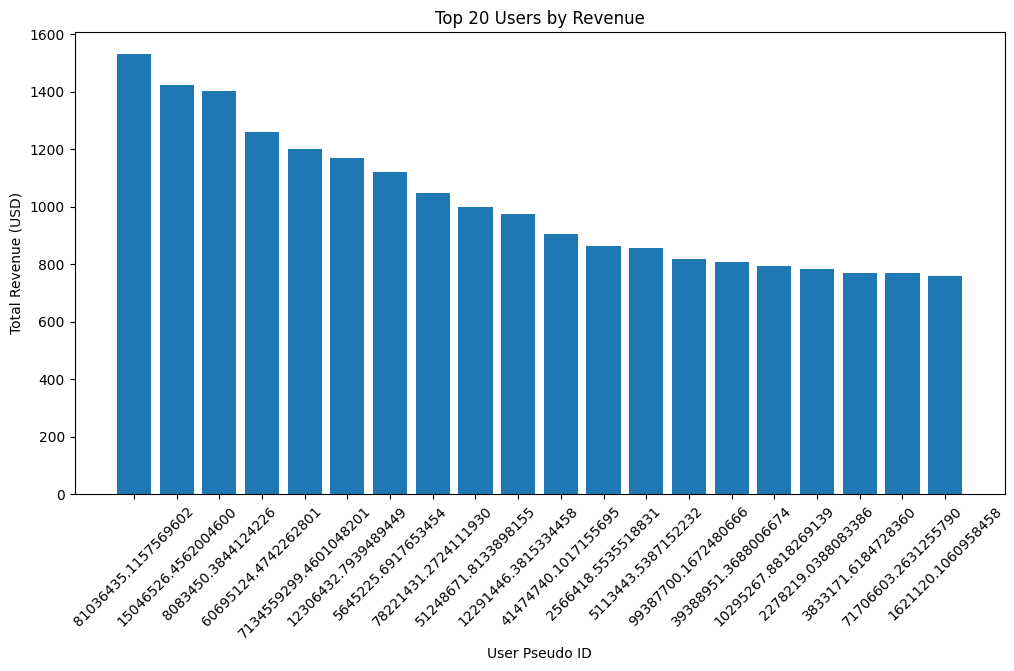

In [10]:
# 8. Write a Jupyter notebook to complete the following tasks.
# a) Query raw data from Google Analytics 4 example table bigquery-public-data.ga4_obfuscated_sample_ecommerce
# from the time range  from 2021-01-15 to  2021-01-31 (WHERE _TABLE_SUFFIX between '20210115' and  '20210131')
# Query user_pseudo_id, number of events and total revenue per user. 
# b) Save query results to the destination BigQuery table. Note that data should stay in BigQuery during the
# processing, don’t download a local copy! The destination should be under your own project and data set, like
# my_project_name.G4_daily_user.G4_daily_user_data. You need to create the data set in the BigQuery console
# c) Query data from the table you created. Import data to the local pandas dataframe.
# d) Visualize basic quantities, like a bar chart of revenue for the top 20 customers. 

import pandas as pd
from google.cloud import bigquery

# ----------------------------
# CONFIGURATION
# ----------------------------
PROJECT_ID = "starry-runner-481115-b8"  # your GCP project
DATASET_NAME = "G4_daily_user"           # BigQuery dataset where results will be saved
TABLE_NAME = "G4_daily_user_data"        # destination table

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# ---------------------------------------------
# 1. Detect valid table suffixes
# ---------------------------------------------
suffix_query = """
SELECT _TABLE_SUFFIX AS table_suffix
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.*`
GROUP BY _TABLE_SUFFIX
ORDER BY _TABLE_SUFFIX
"""

suffixes_df = client.query(suffix_query).to_dataframe()
valid_suffixes = suffixes_df['table_suffix'].tolist()
print("✅ Valid table suffixes in GA4 sample:", valid_suffixes)

# ---------------------------------------------
# 2. Aggregate user events and revenue
# ---------------------------------------------
# Only use valid suffixes to avoid empty results
suffix_filter = ",".join([f"'{s}'" for s in valid_suffixes])

aggregation_query = f"""
SELECT
    user_pseudo_id,
    COUNT(*) AS num_events,
    SUM(IFNULL(event_value_in_usd, 0)) AS total_revenue
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.*`
WHERE _TABLE_SUFFIX IN ({suffix_filter})
GROUP BY user_pseudo_id
ORDER BY total_revenue DESC
"""

# ---------------------------------------------
# 3. Save results to BigQuery
# ---------------------------------------------
destination = f"{PROJECT_ID}.{DATASET_NAME}.{TABLE_NAME}"
job_config = bigquery.QueryJobConfig(destination=destination)
job_config.write_disposition = "WRITE_TRUNCATE"  # overwrite table if exists

query_job = client.query(aggregation_query, job_config=job_config)
query_job.result()  # wait for the job to complete
print(f"✅ Aggregated data saved to {destination} in BigQuery!")

# ---------------------------------------------
# 4. Load results to pandas (optional)
# ---------------------------------------------
df_users = client.query(f"SELECT * FROM `{destination}`").to_dataframe()
print("Preview of aggregated data:")
print(df_users.head())

# ---------------------------------------------
# 5. Visualize top 20 users by revenue
# ---------------------------------------------
import matplotlib.pyplot as plt

top20 = df_users.nlargest(20, 'total_revenue')
plt.figure(figsize=(12,6))
plt.bar(top20['user_pseudo_id'].astype(str), top20['total_revenue'])
plt.xticks(rotation=45)
plt.xlabel("User Pseudo ID")
plt.ylabel("Total Revenue (USD)")
plt.title("Top 20 Users by Revenue")
plt.show()